# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Импорт необходимых библиотек

In [1]:
import pandas as pd
from pymystem3 import Mystem

## Изучение датасета

In [2]:
df = pd.read_csv('/Users/daniilsobolev/Desktop/ml projects/Предобработка/preprocessing_data.csv')
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Описание данных <br>

**children** — количество детей в семье <br>
**days_employed** — общий трудовой стаж в днях<br>
**dob_years** — возраст клиента в годах<br>
**education** — уровень образования клиента<br>
**education_id** — идентификатор уровня образования<br>
**family_status** — семейное положение<br>
**family_status_id** — идентификатор семейного положения<br>
**gender** — пол клиента<br>
**income_type** — тип занятости<br>
**debt** — имел ли задолженность по возврату кредитов<br>
**total_income** — ежемесячный доход<br>
**purpose** — цель получения кредита<br>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод:<br>

Итак, в таблице двенадцать столбцов. <br>
В каждой строке таблицы — данные о клиентах. 

__Каждый столбец описывает:__<br>
1) Личные данные заёмщика: _общий трудовой стаж в днях, возраст в годах, уровень образования, пол, тип занятости, ежемесячный доход, была ли задолженность по возврату кредитов_; <br>
2) Семейное положение: _количество детей в семье, семейный статус_;<br>
3) Цель займа: _цель получения кредита_. <br>
_Остальные столбцы являются идентификаторами других: идентификатор уровня образования, идентификатор семейного положения._<br> 

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных. Также необходимо проверить данные на наличие дубликатов. Названия столбцов записаны корректно.

Первое, что сделаем, устраним проблемы в данных.<br> 
Далее проанализируем данные, чтобы разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

## Шаг 2. Предобработка данных

### Подготовим таблицу к работе

Первое, что сделаем - поменяем в столбцах типа string все буквы на строчные

In [4]:
column_object = ['education', 'family_status', 'gender', 'income_type', 'purpose']

for name in column_object:
    df[name] = df[name].str.lower()

Второе, что бросается в глаза - отрицательные значения в столбце days_employed. Исправим на абсолютные.

In [5]:
df['days_employed'] = df['days_employed'].abs()

Третье, что бросается в глаза - очень большой стаж у пенсионера в 5 строке. Настолько большой, что превышает годы жизни.<br>
Проверим, у всех ли пинсонеров встречается такое.

In [6]:
display(df.groupby('dob_years')['days_employed'].median().to_frame().tail(20))
display(df[df['income_type'] == 'пенсионер'])

,days_employed
dob_years,
56,6850.179463
57,333953.491811
58,331245.976666
59,344372.337365
60,349414.537285
61,343984.931910
62,354981.718187
63,358482.295938
64,355781.562599


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу
12,0,NaN,65,среднее,1,гражданский брак,1,m,пенсионер,0,NaN,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,f,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,не женат / не замужем,4,f,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,m,пенсионер,0,55112.757732,покупка недвижимости
...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,338904.866406,53,среднее,1,гражданский брак,1,m,пенсионер,0,75439.993167,сыграть свадьбу
21508,0,386497.714078,62,среднее,1,женат / замужем,0,m,пенсионер,0,72638.590915,недвижимость
21509,0,362161.054124,59,высшее,0,женат / замужем,0,m,пенсионер,0,73029.059379,операции с недвижимостью
21518,0,373995.710838,59,среднее,1,женат / замужем,0,f,пенсионер,0,153864.650328,сделка с автомобилем


Видно, что у всех клиентов-пенсионеров есть эта проблема в данных. Скорее всего стаж записали не в днях, а в часах. Исправим.

In [7]:
df.loc[df['income_type'] == 'пенсионер','days_employed'] = df[df['income_type'] == 'пенсионер']['days_employed'] / 24

In [8]:
display(df.groupby('dob_years')['days_employed'].median().to_frame().tail(30))

,days_employed
dob_years,
46,2100.473217
47,2203.078545
48,2429.674518
49,2560.317106
50,2626.986257
51,2846.080700
52,3395.639568
53,3650.007523
54,4026.541145


Видно, что есть следующая специфика в данных:

Например, у клиентов 51г и 57г большая разница в днях работы.

Можно сообщить об этом заказчику и запросить детальную выгрузку данных.

Далее проверим, всё ли в порядке с колонкой children

In [9]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Видно, что встречаются отрицательные значение. 
И значение 20 и при этом нигде не встрачется значение 2, что является самым распространенным значением.
Можем сделать вывод, что в данных ошибка, поменяем значение 20 на значение 2.

In [10]:
df.loc[df['children'] == 20,'children'] = 2
df['children'] = df['children'].abs()

df['children'].unique()

array([1, 0, 3, 2, 4, 5])

Теперь проверим столбцы: __education_id, family_status_id, gender, debt__

In [11]:
columns = ['education', 'education_id', 'family_status', 'family_status_id', 'gender', 'debt']

for name in columns:
    print(df[name].unique())

['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
[0 1 2 3 4]
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'не женат / не замужем']
[0 1 2 3 4]
['f' 'm' 'xna']
[0 1]


Видно, что с данными всё в порядке. <br>
Также на вский случай, если вдруг в колонке total_income есть отрицательные значения, поменяем их на абсолютные.<br>

In [12]:
df['total_income'] = df['total_income'].abs()

In [13]:
#Ещё раз выведем таблицу
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.753002,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу


### Обработка пропусков

In [14]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Видно, что выделяются столбцы: days_employed, total_income; в них есть нулевые значения. 
Причем и там и там одинаковое количество. Скорее всего пропуски связаны с одним и тем же обстоятельством.

days_employed определяет общий трудовой стаж в днях <br>
total_income определяет ежемесячный доход

Обе переменные количественные. Количественные переменные обычно заменяются на среднеарифметическое или медианное значение.<br>
Так как дни работы и зарплата могут сильно различаться, заменим значения на медианное.

In [15]:
df['days_employed'] = df['days_employed'].fillna(value=df['days_employed'].median())

df['total_income'] = df['total_income'].fillna(value=df['total_income'].median())

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Замена типа данных

Есть два столбца типо float64, их следовалы бы заменить на столбцы со значением int64<br>
Остальные столбцы можно оставить в прежнем виде<br>

Замену в данном случае лучше производить с помощью метода astype()

In [17]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


### Обработка дубликатов

Удаляем дубли после полной обработки данных:

In [19]:
df.duplicated().sum()

71

In [20]:
df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print('Осталось дубликатов:', df.duplicated().sum())

Осталось дубликатов: 0


### Лемматизация

Для того, чтобы проанализировать влияет ли цель кредита на факт погашения, надо проанализировать столбец '__purpose__'
Лемматизируем этот столбец и сохраним результат с столбце 'lemma_purpose'

In [21]:
m = Mystem()

df['lemma_purpose'] = df['purpose'].apply(m.lemmatize)

Installing mystem to /Users/daniilsobolev/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-macosx.tar.gz


Посмотрим какие категории были выделены в ходе лемматизации:

In [22]:
display(df['purpose'].unique())

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Видно, что цели можно разбить на несколько каьегорий: __жилье, недвижимость, автомобиль, образование, свадьба__<br>

### Категоризация данных

Для анализа, нам нужно категоризировать данные в столбце цель.<br>
Выделим основные категории.

In [23]:
def lemma_purpose(purpose):
    if 'жилье' in purpose:
        return 'жилье'
    if 'недвижимость' in purpose:
        return 'недвижимость'
    if 'автомобиль' in purpose:
        return 'автомобиль'
    if 'образование' in purpose:
        return 'образование'
    if 'свадьба' in purpose:
        return 'свадьба'
    return '0'

df['lemma_purpose'] = df['lemma_purpose'].apply(lemma_purpose)

In [24]:
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemma_purpose
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,образование
4,0,14177,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,свадьба


Также, чтобы ответить есть ли связь между уровнем дохода и возвратом кредита срок, нам нужно категоризировать данные по столбцу 'доходы'

In [25]:
def category_income(total_income):
    if total_income <= 100000:
        return 'низкий уровень длхлда'
    if total_income <= 300000:
        return 'средний уровень дохода'
    return 'высокий уровень дохода'

df['category_income'] = df['total_income'].apply(category_income)
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemma_purpose,category_income
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,жилье,средний уровень дохода
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний уровень дохода
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,жилье,средний уровень дохода
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,образование,средний уровень дохода
4,0,14177,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,свадьба,средний уровень дохода


## Шаг 3. Ответы на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [26]:
df_grouped = df.groupby('children').agg({'debt': ['count', 'sum']})
df_grouped['ratio'] = df_grouped['debt']['sum'] / df_grouped['debt']['count']
df_grouped = df_grouped.sort_values(by='ratio')

display(df_grouped)

debt           ratio
          count   sum          
children                       
5             9     0  0.000000
0         14091  1063  0.075438
3           330    27  0.081818
1          4855   445  0.091658
2          2128   202  0.094925
4            41     4  0.097561

**Вывод**<br>
Для семей с пятью и четыремя детьми в таблице мало данных, поэтому выводы по ним сделать не можем.<br>
Для остальных семей видно следующее, что если в семье трое детей, то вероятность возврата в срок больше<br>
И наоборот, для семей с двумя детьми вероятность возврата в срок самая низкая из всех.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [27]:
df_grouped = df.groupby('family_status').agg({'debt': ['count', 'sum']})
df_grouped['ratio'] = df_grouped['debt']['sum'] / df_grouped['debt']['count']
df_grouped = df_grouped.sort_values(by='ratio')

display(df_grouped)

debt          ratio
                       count  sum          
family_status                              
вдовец / вдова           959   63  0.065693
в разводе               1195   85  0.071130
женат / замужем        12339  931  0.075452
гражданский брак        4151  388  0.093471
не женат / не замужем   2810  274  0.097509

**Вывод**<br>
Видно, что если клиент вдовец/вдова, то вероятность возврата в срок наивысшая.<br>
Что напротив, если клиент не женат/не замужем, то вероятность возврата самая низкая 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [28]:
df_grouped = df.groupby('category_income').agg({'debt': ['count', 'sum']})
df_grouped['ratio'] = df_grouped['debt']['sum'] / df_grouped['debt']['count']
df_grouped = df_grouped.sort_values(by='ratio')

display(df_grouped)

debt           ratio
                        count   sum          
category_income                              
высокий уровень дохода   1482   106  0.071525
низкий уровень длхлда    4463   354  0.079319
средний уровень дохода  15509  1281  0.082597

**Вывод**<br>
Видно, что если уровень дохода выше, то вероятность возврата выше, <br>
При этом! Вероятность воврата ниже у клиентов со средним уровнем дохода (100-300 т.р.)

- Как разные цели кредита влияют на его возврат в срок?

In [29]:
df_grouped = df.groupby('lemma_purpose').agg({'debt': ['count', 'sum']})
df_grouped['ratio'] = df_grouped['debt']['sum'] / df_grouped['debt']['count']
df_grouped = df_grouped.sort_values(by='ratio')

display(df_grouped)

debt          ratio
              count  sum          
lemma_purpose                     
жилье          4460  308  0.069058
недвижимость   6351  474  0.074634
свадьба        2324  186  0.080034
образование    4013  370  0.092200
автомобиль     4306  403  0.093590

**Вывод**
Видно, что цель кредита влияет на возврат кредита в срок. 
К примеру, мы видим, что если цель - покупка жилья, тогда возврат кредита выше в отлчие от других рассмтриваемых слечаев 
А вероятность воврат кредита на автомобиль самая низкая из рассматриваемых. 

## Шаг 4. Общий вывод

Из полученных таблиц видно, что семейное положение и количество детей влияет на факт погашения кредита в срок.<br>
Например, самым благоприяьным клиентом для банка будет вдовец/вдова без детей. <br>
А самым неблагоприятным - если клиент не женат/не замужем с двумя детьми.

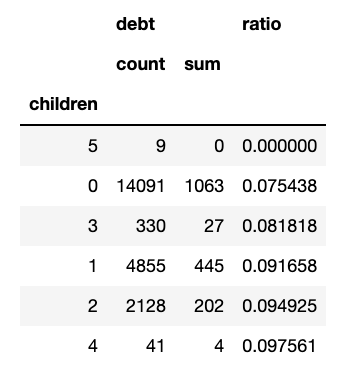

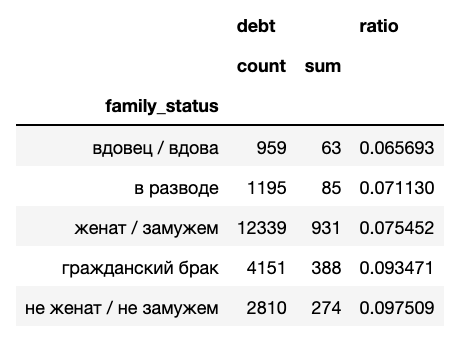